In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import os
import random
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

2024-10-12 03:17:55.409333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-12 03:17:56.144772: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-12 03:17:56.304202: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-12 03:17:56.304256: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [2]:
RANDOM_SEED = 42

In [23]:
data_dirs = [
    '/mnt/c/Users/Siam/OneDrive - Tuskegee University/ai-arni-nsf/SAMPLE_dataset_public/png_images/qpm/real',
    '/mnt/c/Users/Siam/OneDrive - Tuskegee University/ai-arni-nsf/SAMPLE_dataset_public/png_images/qpm/synth',
    '/mnt/c/Users/Siam/OneDrive - Tuskegee University/ai-arni-nsf/SAMPLE_dataset_public/png_images/decibel/real',
    '/mnt/c/Users/Siam/OneDrive - Tuskegee University/ai-arni-nsf/SAMPLE_dataset_public/png_images/decibel/synth'
]

In [3]:
architecture_names = [
    'cnn',
    'resnet50',
    'resnet101',
    'resnet152',
    'efficientnetb0',
    'vgg16',
    'vgg19',
    'inceptionv3',
    'unet'
]

classifiers = ['random_forest', 'svm', 'gradient_boosting', 'xgboost']

In [4]:
# Set seeds for reproducibility
def set_random_seeds(seed=RANDOM_SEED):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [5]:
# Step 1: Load Data with Color Mode Option
def load_data_from_directory(data_dir, img_size=(64, 64), color_mode='grayscale'):
    images = []
    labels = []
    
    class_folders = os.listdir(data_dir)
    for class_index, class_folder in enumerate(class_folders):
        class_path = os.path.join(data_dir, class_folder)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                image = load_img(img_path, target_size=img_size, color_mode=color_mode)
                image = img_to_array(image) / 255.0 # Normalised to [0, 1]
                images.append(image)
                labels.append(class_index)
    
    print(f'> {len(images)} files loaded of size {images[0].shape} with {len(labels)} labels')
    return np.array(images), np.array(labels)

In [6]:
# Step 2: Data Augmentation with diverse transformations (Rotation, Brightness, Scaling, Translation, etc.)
def augment_image(image, rotation_angle):
    """Apply a diverse set of augmentations to the image."""
    '''
    image = tf.image.random_flip_left_right(image)  # Flip horizontally
    image = tf.image.random_brightness(image, max_delta=0.2)  # Brightness adjustment
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Contrast adjustment
    image = tf.image.random_zoom(image, (0.8, 1.2))  # Zooming simulation
    image = tf.image.random_translation(image, translations=[5, 5])  # Random Translation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)  # Saturation adjustment
    image = tf.image.random_hue(image, max_delta=0.2)  # Hue adjustment
    image = tf.image.random_jpeg_quality(image, min_jpeg_quality=50, max_jpeg_quality=100)  # JPEG quality jitter
    image = tf.image.resize_with_crop_or_pad(image, 70, 70)  # Zooming simulation via resizing
    image = tf.image.random_crop(image, size=[64, 64, 1])  # Crop back to original size
    '''
    # Apply rotation (keeping the original logic)
    # rotation_angle = np.random.choice([0, 90, 180, 270])
    if rotation_angle == 90:
        image = tf.image.rot90(image)
    elif rotation_angle == 180:
        image = tf.image.rot90(image, k=2)
    elif rotation_angle == 270:
        image = tf.image.rot90(image, k=3)

    label = rotation_angle // 90
    return image, label

In [7]:
def preprocess_data(images):
    augmented_images = []
    labels = []
    for image in images:
        for rotation_angle in [0, 90, 180, 270]:
            aug_image, label = augment_image(image, rotation_angle)
            augmented_images.append(aug_image)
            labels.append(label)
    print(f'> {len(augmented_images)} augmented images generated each of shape {augmented_images[0].shape} with {len(labels)} labels')
    return np.array(augmented_images), np.array(labels)

In [8]:
# Step 3: Balanced Sampling using Oversampling (Copies data from minor class to balance number of samples)
def balance_classes(x_data, y_data):
    ros = RandomOverSampler(random_state=RANDOM_SEED)
    x_flattened = x_data.reshape((x_data.shape[0], -1))  # Reshape to 2D for balancing
    x_resampled, y_resampled = ros.fit_resample(x_flattened, y_data)
    x_resampled = x_resampled.reshape((-1, x_data.shape[1], x_data.shape[2], x_data.shape[3]))  # Reshape back to original
    print(f'> (balancing) resampled to {x_resampled.shape[0]} samples')
    return x_resampled, y_resampled

In [11]:
# Helper function to build U-Net (custom   implementation)
def build_unet_model(input_shape=(64, 64, 3)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoding (down-sampling) path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Bridge (bottom of the U-Net)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    
    # Decoding (up-sampling) path
    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.Concatenate()([u1, c2])
    
    u2 = layers.UpSampling2D((2, 2))(u1)
    u2 = layers.Concatenate()([u2, c1])
    
    outputs = layers.Conv2D(3, (1, 1), activation='softmax')(u2)
    
    return models.Model(inputs=inputs, outputs=outputs)

In [14]:
# TODO make size variable
def build_custom_cnn_model(input_shape=(64, 64, 1), num_classes=4, architecture_name=None, fine_tune=True):
    print(f'> pretext task training: input_shape {input_shape}, num_classes {num_classes}, architecture_name {architecture_name}')
    
    inputs = tf.keras.Input(shape=input_shape)
    
    if architecture_name != 'cnn':
        # Upsample input to the required size if needed (InceptionV3 requires minimum 75x75)
        if architecture_name == 'inceptionv3' and (input_shape[0] < 75 or input_shape[1] < 75):
            required_size = (75, 75)  # InceptionV3 minimum size
        else:
            required_size = (input_shape[0], input_shape[1])  # Default size for other models
            
        x = layers.Resizing(required_size[0], required_size[1])(inputs)  # Resize input to required size

        # Convert grayscale (1-channel) to 3-channel RGB for pretrained models
        x = layers.Conv2D(3, (1, 1))(x)
        
        # Pretrained model selection logic
        # ResNet Variants
        if architecture_name == 'resnet50':
            from tensorflow.keras.applications import ResNet50
            base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(required_size[0], required_size[1], 3))
        elif architecture_name == 'resnet101':
            from tensorflow.keras.applications import ResNet101
            base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(required_size[0], required_size[1], 3))
        elif architecture_name == 'resnet152':
            from tensorflow.keras.applications import ResNet152
            base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(required_size[0], required_size[1], 3))
        
        # EfficientNetB0
        elif architecture_name == 'efficientnetb0':
            from tensorflow.keras.applications import EfficientNetB0
            base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(required_size[0], required_size[1], 3))

        # VGGNet Variants
        elif architecture_name == 'vgg16':
            from tensorflow.keras.applications import VGG16
            base_model = VGG16(weights='imagenet', include_top=False, input_shape=(required_size[0], required_size[1], 3))
        elif architecture_name == 'vgg19':
            from tensorflow.keras.applications import VGG19
            base_model = VGG19(weights='imagenet', include_top=False, input_shape=(required_size[0], required_size[1], 3))

        # InceptionV3
        elif architecture_name == 'inceptionv3':
            from tensorflow.keras.applications import InceptionV3
            base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(required_size[0], required_size[1], 3))

        # U-Net (not from Keras applications, custom U-Net function)
        elif architecture_name == 'unet':
            base_model = build_unet_model(input_shape=(required_size[0], required_size[1], 3))  # Custom function to build U-Net model

        # Set base model to non-trainable if fine-tuning is disabled
        if not fine_tune:
            base_model.trainable = False
        
        # Apply base model to input
        x = base_model(x, training=fine_tune)
        x = GlobalAveragePooling2D()(x)

    else:
        # Build a custom CNN if no pretrained model is specified
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(inputs)
        x = BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
        x = BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
        x = BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
        x = BatchNormalization()(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dropout(0.5)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    return model

In [15]:
# Loop through each model name and build the model
for model_name in architecture_names:
    print(f"\nBuilding model: {model_name}")
    model = build_custom_cnn_model(input_shape=(128, 128, 1), num_classes=4, architecture_name=model_name, fine_tune=True)


Building model: cnn
> pretext task training: input_shape (128, 128, 1), num_classes 4, architecture_name cnn
Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_220 (Conv2D)         (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_196 (Ba  (None, 128, 128, 32)     128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_221 (Conv2D)         (None, 64, 64, 64)        18496     
              

In [10]:
# Function to save the trained model
def save_model(model, architecture_name, data_dir):
    model_name = f"{architecture_name}_model_{os.path.basename(data_dir)}.h5"
    model.save(model_name)
    print(f"Model saved as {model_name}")

# Function to load the saved model
def load_model(architecture_name, data_dir):
    model_name = f"{architecture_name}_model_{os.path.basename(data_dir)}.h5"
    model = tf.keras.models.load_model(model_name)
    print(f"Model loaded from {model_name}")
    return model

In [16]:
# Step 5: Feature Extraction from deeper layers
def extract_features(pretext_model, x_data, layer_index=-2):
    intermediate_model = models.Model(inputs=pretext_model.input, outputs=pretext_model.layers[layer_index].output)
    print('> intermediate feature extractor model:')
    intermediate_model.summary()
    features = intermediate_model.predict(x_data)
    print(f'> extracted features of shape {features.shape}')
    return features

In [17]:
# Step 6: Downstream Task Training (RandomForest, SVM, Gradient Boosting, XGBoost)
def train_downstream_task(train_features, train_labels, classifier='random_forest', n_splits=5):
    print(f'> performing downstream task with {classifier}')
    if classifier == 'random_forest':
        clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
    elif classifier == 'svm':
        clf = SVC(kernel='linear', random_state=RANDOM_SEED)
    elif classifier == 'gradient_boosting':
        clf = GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED)
    elif classifier == 'xgboost':
        clf = XGBClassifier(n_estimators=100, random_state=RANDOM_SEED, use_label_encoder=True
        #  TODO clf = XGBClassifier(n_estimators=100, random_state=RANDOM_SEED, use_label_encoder=False, eval_metric='logloss')

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    accuracies, precisions, recalls, f1_scores = [], [], [], []
    
    for train_index, test_index in skf.split(train_features, train_labels):
        X_train, X_test = train_features[train_index], train_features[test_index]
        y_train, y_test = train_labels[train_index], train_labels[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average='macro'))
        recalls.append(recall_score(y_test, y_pred, average='macro'))
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))

    print(f'> [RESULT] Accuracy: {np.mean(accuracies) * 100:.2f}%')
    print(f'> [RESULT] Precision: {np.mean(precisions) * 100:.2f}%')
    print(f'> [RESULT] Recall: {np.mean(recalls) * 100:.2f}%')
    print(f'> [RESULT] F1-score: {np.mean(f1_scores) * 100:.2f}%')

In [18]:
# Step 7: Plot Results
def plot_results(history):
    plt.figure(figsize=(12, 4))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over epochs')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()

    plt.show()
    plt.close()
    print()

In [20]:
def run_pretext_pipeline(data_dir, architecture_name='cnn'):
    print(f'>>> BEGIN PRETEXT TASK\n> folder: {data_dir}\n> {architecture_name}')
    # Load data
    x_data, y_data = load_data_from_directory(data_dir)

    # Augment Data
    x_augmented, y_augmented = preprocess_data(x_data)

    # Balance Data
    x_balanced, y_balanced = balance_classes(x_augmented, y_augmented)

    # Build and Train Pretext Task Model
    pretext_model = build_custom_cnn_model(
        input_shape=(64, 64, 1), 
        num_classes=4, 
        architecture_name=architecture_name, 
        fine_tune=False
    )
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    history = pretext_model.fit(x_balanced, y_balanced, epochs=10, validation_split=0.25, callbacks=[early_stopping, lr_scheduler])

    # Plot Results
    plot_results(history)

    # Save the trained model
    save_model(pretext_model, architecture_name, data_dir)

    print(f'> folder: {data_dir}\n> {architecture_name}\n>>> END PRETEXT TASK\n\n')

In [21]:
def run_downstream_pipeline(data_dir, architecture_name='cnn', downstream_classifier='random_forest', layer_index=-2):
    print(f'>>> BEGIN DOWNSTREAM TASK\n> folder: {data_dir}\n> {architecture_name} | {downstream_classifier}')
    
    # Load data
    x_data, y_data = load_data_from_directory(data_dir)

    # Load the saved pretext model
    pretext_model = load_model(architecture_name, data_dir)

    # Extract Features
    train_features = extract_features(pretext_model, x_data, layer_index=layer_index)

    # Train the Downstream Task
    train_downstream_task(train_features, y_data, classifier=downstream_classifier)

    print(f'> folder: {data_dir}\n> {architecture_name} | {downstream_classifier}\n>>> END DOWNSTREAM TASK\n\n')

>>> BEGIN PRETEXT TASK
> folder: /mnt/c/Users/Siam/OneDrive - Tuskegee University/ai-arni-nsf/SAMPLE_dataset_public/png_images/qpm/real
> cnn
> 1345 files loaded of size (64, 64, 1) with 1345 labels
> 5380 augmented images generated each of shape (64, 64, 1) with 5380 labels
> (balancing) resampled to 5380 samples
> pretext task training: input_shape (64, 64, 1), num_classes 4, architecture_name cnn
Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_342 (Conv2D)         (None, 64, 64, 32)        320       
                                                                 
 batch_normalization_306 (Ba  (None, 64, 64, 32)       128       
 tchNormalization)                                               
                                                   

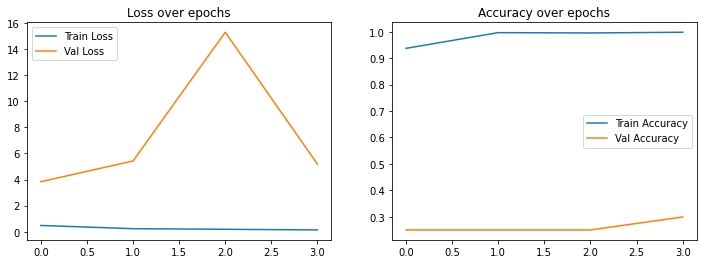


Model saved as cnn_model_real.h5
> folder: /mnt/c/Users/Siam/OneDrive - Tuskegee University/ai-arni-nsf/SAMPLE_dataset_public/png_images/qpm/real
> cnn
>>> END PRETEXT TASK




In [27]:
# First, run all pretext tasks
for data_dir in data_dirs[:1]:
    for architecture_name in architecture_names[:1]:
        run_pretext_pipeline(data_dir, architecture_name)

In [ ]:
# Then, (of course in different cell) run all downstream tasks
for data_dir in data_dirs[:1]:
    for architecture_name in architecture_names[:1]:
        for classifier in classifiers[:1]:
            run_downstream_pipeline(data_dir, architecture_name, classifier, -2)